In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../src')
from functions import *

In [2]:
testset = pd.read_csv('../Data/01_raw/attrition_test.csv', low_memory = False)
trainset = pd.read_csv('../Data/01_raw/attrition_train.csv', low_memory = False)

## Data exploratory

In [3]:
trainset.shape

(1100, 35)

In [5]:
trainset = trainset.dropna()
trainset = trainset.drop(['JobLevel', 'StandardHours', 'EmployeeCount', 'Over18', 'PerformanceRating', 'Education', 'DailyRate'], axis = 1)

In [7]:
categorical_cols = trainset.select_dtypes(include='object').columns
categorical_cols = categorical_cols.drop('Attrition')

In [8]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
enc = OrdinalEncoder()
trainset["Attrition"] = enc.fit_transform(trainset[["Attrition"]])

In [9]:
one_hot = pd.get_dummies(trainset[categorical_cols])
# Drop column B as it is now encoded
trainset = trainset.drop(categorical_cols, axis = 1)
# Join the encoded df
trainset = trainset.join(one_hot)

In [10]:
trainset.dtypes

Age                                    int64
Attrition                            float64
DistanceFromHome                       int64
EmployeeNumber                         int64
EnvironmentSatisfaction                int64
HourlyRate                             int64
JobInvolvement                         int64
JobSatisfaction                        int64
MonthlyIncome                          int64
MonthlyRate                            int64
NumCompaniesWorked                     int64
PercentSalaryHike                      int64
RelationshipSatisfaction               int64
StockOptionLevel                       int64
TotalWorkingYears                      int64
TrainingTimesLastYear                  int64
WorkLifeBalance                        int64
YearsAtCompany                         int64
YearsInCurrentRole                     int64
YearsSinceLastPromotion                int64
YearsWithCurrManager                   int64
BusinessTravel_Non-Travel              uint8
BusinessTr

In [11]:
trainset.head(5)

,Age,Attrition,DistanceFromHome,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyIncome,MonthlyRate,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,38,0.0,2,803,1,75,4,1,5980,26085,...,1,0,0,0,0,0,0,1,0,1
1,52,0.0,28,1401,4,59,4,3,13247,9731,...,1,0,0,0,0,0,1,0,0,1
2,28,0.0,1,1315,3,55,1,4,6674,16392,...,0,0,0,0,0,0,1,0,1,0
3,43,0.0,3,1255,3,96,1,4,19740,18625,...,0,1,0,0,0,0,1,0,1,0
4,27,0.0,3,850,4,50,3,4,1706,16571,...,0,0,1,0,0,0,1,0,1,0


## TrainTest - Encodage - Nettoyage

In [12]:
trainset = encodage(trainset)
trainset = imputation(trainset)
    
X = trainset.drop(['Attrition'], axis=1)
y = trainset['Attrition']

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Modelisation

In [14]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import PolynomialFeatures

In [15]:
RandomForest = RandomForestClassifier(max_depth = 6, n_estimators = 100, min_samples_split = 10, min_samples_leaf = 5, criterion = 'entropy', random_state= 0)
AdaBoost = AdaBoostClassifier(learning_rate = 0.1, n_estimators = 100, random_state=0)
SVC = make_pipeline(StandardScaler(), SVC(gamma=0.005, C = 30, kernel = 'rbf', random_state=0, probability = True))
KNN = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors = 15))
Logistic = make_pipeline(StandardScaler(), LogisticRegression(penalty = 'l2', C = 0.08, solver = 'newton-cg', max_iter = 550, random_state=0))
XGB = XGBClassifier(n_estimators = 400, objective = 'reg:logistic', learning_rate = 0.05, gamma = 0.3, colsample_bytree = 0.3, min_child_weight = 2, max_depth = 10, random_state= 0)

In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import sklearn.metrics as metrics
from sklearn.feature_selection import RFECV

In [17]:
def get_features_ranking(model):
    selector = RFECV(model,
                    step = 1,
                    min_features_to_select= 2,
                    cv = 5)

    selector.fit(X,y)

    cols = selector.get_support(indices=True)
    print(cols)
    features_df_new = trainset.iloc[:,cols]
    print(features_df_new.columns)

In [18]:
def display_roc(model):
    """calculate the AUC score for the model specified"""
    # calculate the fpr and tpr for all thresholds of the classification
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [19]:
def get_roc_auc_score(model):
    """return Train and Test ROC AUC SCORE of the model"""

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    print('Train ROC AUC SCORE : {}'.format(round(roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]), 3)))
    print('Test ROC AUC SCORE : {}'.format(round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]), 3)))
    print('\n') 

    display_roc(model)

[[183   1]
 [ 34   2]]
              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91       184
         1.0       0.67      0.06      0.10        36

    accuracy                           0.84       220
   macro avg       0.75      0.53      0.51       220
weighted avg       0.81      0.84      0.78       220

Train ROC AUC SCORE : 0.96
Test ROC AUC SCORE : 0.78




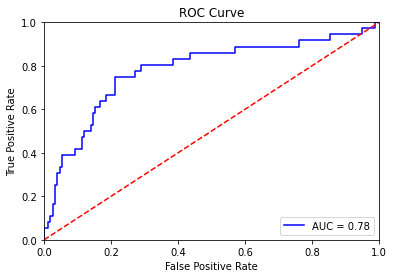

In [20]:
get_roc_auc_score(RandomForest)

[[183   1]
 [ 34   2]]
              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91       184
         1.0       0.67      0.06      0.10        36

    accuracy                           0.84       220
   macro avg       0.75      0.53      0.51       220
weighted avg       0.81      0.84      0.78       220

Train ROC AUC SCORE : 0.892
Test ROC AUC SCORE : 0.785




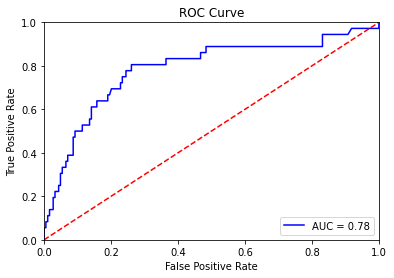

In [21]:
get_roc_auc_score(AdaBoost)

[[183   1]
 [ 35   1]]
              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91       184
         1.0       0.50      0.03      0.05        36

    accuracy                           0.84       220
   macro avg       0.67      0.51      0.48       220
weighted avg       0.78      0.84      0.77       220

Train ROC AUC SCORE : 0.851
Test ROC AUC SCORE : 0.703




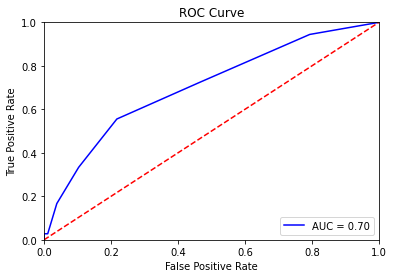

In [22]:
get_roc_auc_score(KNN)

[[174  10]
 [ 21  15]]
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92       184
         1.0       0.60      0.42      0.49        36

    accuracy                           0.86       220
   macro avg       0.75      0.68      0.71       220
weighted avg       0.84      0.86      0.85       220

Train ROC AUC SCORE : 0.983
Test ROC AUC SCORE : 0.836




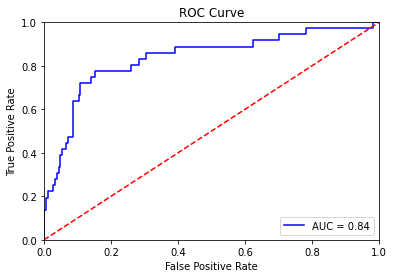

In [23]:
get_roc_auc_score(SVC)

In [36]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

In [37]:
f_importances(SVC.coef_, X)

AttributeError: 'Pipeline' object has no attribute 'coef_'

[[175   9]
 [ 26  10]]
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91       184
         1.0       0.53      0.28      0.36        36

    accuracy                           0.84       220
   macro avg       0.70      0.61      0.64       220
weighted avg       0.81      0.84      0.82       220

Train ROC AUC SCORE : 0.888
Test ROC AUC SCORE : 0.829




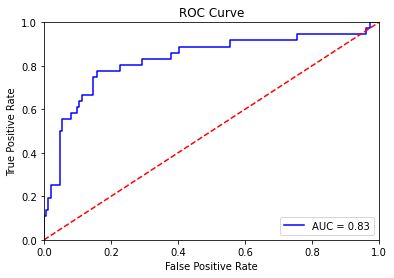

In [24]:
get_roc_auc_score(Logistic)

[[179   5]
 [ 27   9]]
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92       184
         1.0       0.64      0.25      0.36        36

    accuracy                           0.85       220
   macro avg       0.76      0.61      0.64       220
weighted avg       0.83      0.85      0.83       220

Train ROC AUC SCORE : 1.0
Test ROC AUC SCORE : 0.802




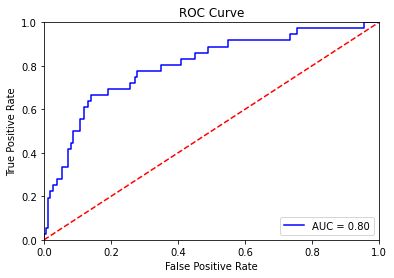

In [25]:
get_roc_auc_score(XGB)

## Prédictions sur le testset

In [26]:
testset = testset.dropna()
testset = testset.drop(['JobLevel', 'StandardHours', 'EmployeeCount', 'Over18', 'PerformanceRating', 'Education', 'DailyRate', 'index1'], axis = 1)

In [27]:
categorical_cols = testset.select_dtypes(include='object').columns

In [28]:
one_hot = pd.get_dummies(testset[categorical_cols])
# Drop column B as it is now encoded
testset = testset.drop(categorical_cols, axis = 1)
# Join the encoded df
testset = testset.join(one_hot)

In [29]:
testset = encodage(testset)
testset = imputation(testset)

In [30]:
SVC.fit(X_train, y_train)
y_pred = SVC.predict(testset)
    
testset['Attrition'] = SVC.predict(testset)

In [31]:
testset['Attrition'].value_counts()
testset.head(5)

,Age,DistanceFromHome,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,41,1,1,2,94,3,4,5993,19479,8,...,0,0,1,0,0,0,1,0,1,1.0
1,49,8,2,3,61,2,2,5130,24907,1,...,0,1,0,0,0,1,0,1,0,0.0
2,27,2,7,1,40,3,2,3468,16632,9,...,0,0,0,0,0,1,0,1,0,1.0
3,32,2,8,4,79,3,4,3068,11864,0,...,0,0,0,0,0,0,1,1,0,0.0
4,29,21,20,2,51,4,1,9980,10195,1,...,0,0,0,0,1,0,0,1,0,0.0


In [32]:
yes_attrition = testset.loc[testset['Attrition'] == 1]
yes_attrition

,Age,DistanceFromHome,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Attrition
0,41,1,1,2,94,3,4,5993,19479,8,...,0,0,1,0,0,0,1,0,1,1.0
2,27,2,7,1,40,3,2,3468,16632,9,...,0,0,0,0,0,1,0,1,0,1.0
5,22,16,22,4,96,4,4,2935,7324,1,...,0,0,0,0,1,0,0,0,1,1.0
10,28,5,65,3,50,3,3,3441,11179,1,...,0,0,0,0,0,0,1,0,1,1.0
11,35,23,75,3,30,3,1,4014,16002,3,...,0,0,0,0,0,1,0,0,1,1.0
23,20,6,137,4,66,2,4,2926,19783,1,...,0,0,0,0,0,0,1,0,1,1.0
25,25,5,142,3,46,2,3,5744,26959,1,...,0,0,1,0,0,0,1,0,1,1.0
31,19,22,167,4,50,3,3,1675,26820,1,...,0,0,0,1,0,0,1,0,1,1.0
49,27,1,274,3,60,2,1,4298,9679,5,...,0,0,0,0,0,1,0,1,0,1.0
54,30,26,299,3,52,2,1,6696,22967,5,...,0,0,1,0,0,0,1,1,0,1.0


In [ ]:
path = '../Data/02_processed'
testset.to_csv(path,'predict_attrition.csv')